Elo: Predicting Matchup Outcome Probability 
==

- Part 1: Elo Implementation
    - Matchup Outcome Probability
    - Rating Assignment

- Part 2
    - Simulation Environment

In [538]:
import math
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

In [539]:
# Helper function to "prettify" outputs
def log_dict(output: list[list[int]]) -> str:
    return tabulate(output, headers=["Outcome", "Win %", "Loss %"])

def log_dict_sim(output: list[list[int]]) -> str:
    return tabulate(output, headers=["Outcome", "Prob. %"])

Elo: Probabilistic Distribution
--

There are two valid distribution functions that can be used with Elo: normal and logistic distributions. Arpad Elo initially suggested normal distribution, but now adays many organizations in chess like USCF and FIDE have both transitioned to modified logistical distributions. 

> "Subsequent statistical tests have suggested that chess performance is almost certainly not distributed as a normal distribution, as weaker players have greater winning chances than Elo's model predicts."
>
> -- <cite>[Elo rating system](https://en.wikipedia.org/wiki/Elo_rating_system)</cite>
 
 As a point of comparison, both normal and logistic distributions will be implemented below.



In [540]:
# Expected win probability: Normal Distribution
def expected_scores_normal_dis(rat_a: float, rat_b: float) -> str:
    p1_win_prob = p2_loss_prob = 1 / (1 + 10**((rat_b - rat_a) / 400))
    p2_win_prob = p1_loss_prob = 1 / (1 + 10**((rat_a - rat_b) / 400))
    
    output = [["Player 1", p1_win_prob, p1_loss_prob], ["Player 2", p2_win_prob, p2_loss_prob]]
    
    return log_dict(output), p1_win_prob, p2_win_prob

# Expected win probability: Logistic Distribution
"""
Currently, the condition rating1 ≤ rating2 (rat_a ≤ rat_b) must be valid for 
expected_scores_logistic_dis() to run properly.

"""
def expected_scores_logistic_dis(rat_a: float, rat_b: float) -> str:
    def elo_log(elo_diff: float) -> float:
        # abs(elo_diff) instead?
        # Next step will be to make this more adaptable to different inputs
        return math.erfc(-elo_diff / ((2000/7) * math.sqrt(2))) / 2
    # rating1 ≤ rating2 !! 
    diff = rat_a - rat_b
    expected_score = elo_log(diff)
    
    p1_win_prob = p2_loss_prob = elo_log(diff)
    p2_win_prob = p1_loss_prob = 1 - p1_win_prob
    
    output = [["Player 1", p1_win_prob, p1_loss_prob], ["Player 2", p2_win_prob, p2_loss_prob]]
    
    return log_dict(output), p1_win_prob, p2_win_prob

# Plot win probability: Normal vs. Logistic
def plot_dis() -> None:    
    normal_diffs = []
    logistic_diffs = []
    x = 500
    y = 2500
    
    while y >= 500 or x <= 2500:
        normal_diffs.append(expected_scores_normal_dis(x,y)[1])
        logistic_diffs.append(expected_scores_logistic_dis(x,y)[1])
        y -= 1
        x += 1
        
    # Init figure, labels
    fig = plt.figure(figsize=(15,20))
    ax1 = fig.add_subplot(211)
    ax1.set_title("Expected Elo Outcomes: Normal vs Logistic Distribution", fontsize=16)
    ax1.set_xlabel("Rating Difference", fontsize=16)
    ax1.set_ylabel("Win Probability", fontsize=16)
    
    # Plot lines, axes, legend
    plt.plot(range(-1000, -1000+len(normal_diffs)), normal_diffs, label="Normal Dis.")
    plt.plot(range(-1000, -1000+len(logistic_diffs)), logistic_diffs, label="Logistic Dis.")
    plt.legend()
    
    plt.show()

Ex.
Player 1: 2400 Elo, Player 2: 2450 Elo

Elo Expected Score: Normal Distribution
Outcome       Win %    Loss %
---------  --------  --------
Player 1   0.428537  0.571463
Player 2   0.571463  0.428537

Elo Expected Score: Logistic Distribution
Outcome      Win %    Loss %
---------  -------  --------
Player 1   0.43054   0.56946
Player 2   0.56946   0.43054


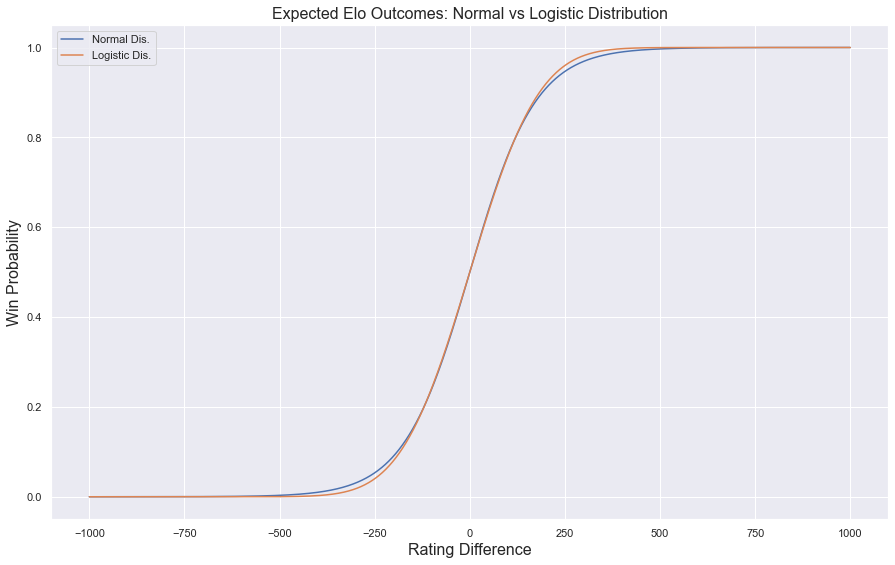

In [541]:
print("Ex.")
print("Player 1: 2400 Elo, Player 2: 2450 Elo\n")
print("Elo Expected Score: Normal Distribution")
print(expected_scores_normal_dis(2400, 2450)[0])
print("\nElo Expected Score: Logistic Distribution")
print(expected_scores_logistic_dis(2400,2450)[0])

plot_dis()

As you can see, both distributions get the job done but we're going to focus on logistic distribution for the rest of the exercise. Now that we have wins and losses accounted for, only draws remain.

Elo: Draws
--


> "The probability of drawing, as opposed to having a decisive result, is not specified in the Elo system."
>
> -- <cite>[Elo rating system](https://en.wikipedia.org/wiki/Elo_rating_system)</cite>

This is not ideal.

![](https://c.tenor.com/u8YEMwIfJGMAAAAC/thanos.gif)

A couple of pseudo implementations found on the internet use a dynamic material odds function to slice out a draw probability from the win/loss total based on the `+0.6` "material advantage" white starts out with on move 1. They also assume that material advantages are much more significant on matchups with a higher average Elo compared to lower rated Elo matchups. Let's add to our `expected_scores()` function.



In [542]:
# H2H := Head to Head (Match, Game, etc...)
def expected_scores(rat_a: float, rat_b: float, log_draw_off=False) -> str:
    def elo_log(elo_diff: float) -> float:
        return math.erfc(-elo_diff / ((2000/7) * math.sqrt(2))) / 2

    def elo_draw_offset(elo: float) -> float:
        # logistic draw offset vs constant draw offset.
        # Should higher rated avg. matchups have a higher draw probability?
        if log_draw_off:
            # H2Hs w/ higher avg Elo draw more
            return math.exp(elo / 1020) * 26.59
        # Draws are only tied to Elo difference, nothing else.
        # This draw constant may need to be tinkered with in the future.
        return 200
    
    diff = rat_a - rat_b
    average = (rat_a + rat_b) / 2
    expected_score = elo_log(diff)
    edo = elo_draw_offset(average)
    
    elo_shift = edo * 0.6

    # Just for clarity, P1 Loss = P2 Win and vice versa
    p1_win_prob = p2_loss_prob = elo_log(diff - elo_shift)
    draw_prob = (expected_score - p1_win_prob) * 2
    p2_win_prob = p1_loss_prob = 1 - (p1_win_prob + draw_prob)

    output = [["P1 Win", p1_win_prob],["P2 Win", p2_win_prob],["Draw", draw_prob]]
    
    return log_dict(output), p1_win_prob, p1_loss_prob, draw_prob

def plot_draw_offset() -> None:
    win_prob = []
    linear_draw_prob = []
    log_draw_prob = []
    
    x = 500
    y = 2500
    
    while y >= 500 or x <= 2500:
        es_linear_draw = expected_scores(x, y)
        es_log_draw = expected_scores(x, y, True)
        
        win_prob.append(es_linear_draw[1])
        linear_draw_prob.append(es_linear_draw[3])
        log_draw_prob.append(es_log_draw[3])

        y -= 1
        x += 1

    # Init figure, labels
    fig = plt.figure(figsize=(15,20))
    ax1 = fig.add_subplot(211)
    ax1.set_title("Expected Draw Outcomes: Logistic vs Linear", fontsize=16)
    ax1.set_xlabel("Rating Difference", fontsize=16)
    ax1.set_ylabel("Outcome Probability ", fontsize=16)

    # Plot lines, axes, legend
    plt.plot(range(-1000, -1000 + len(win_prob)), win_prob, label="Win %")
    plt.plot(range(-1000, -1000 + len(linear_draw_prob)), linear_draw_prob, label="Linear Draw %")
    plt.plot(range(-1000, -1000 + len(log_draw_prob)), log_draw_prob, label="Logistic Draw %")
    plt.legend()

    plt.show()

def plot_draw_avg_rating():
    linear_draw_prob_h2h = []
    log_draw_prob_h2h = []
    
    x = 500
    
    while x <= 2500:        
        es_linear_draw_h2h = expected_scores(x, x)
        es_log_draw_h2h = expected_scores(x, x, True)

        linear_draw_prob_h2h.append(es_linear_draw_h2h[3])
        log_draw_prob_h2h.append(es_log_draw_h2h[3])

        x += 1
    
    # Init figure, labels
    fig = plt.figure(figsize=(15,20))
    ax1 = fig.add_subplot(211)
    ax1.set_title("Expected Draw Outcomes: Logistic vs Linear - Common Rating", fontsize=16)
    ax1.set_xlabel("Head to Head Elo Avg.", fontsize=16)
    ax1.set_ylabel("Draw Probability ", fontsize=16)
    
    # Plot lines, axes, legend
    plt.plot(range(500, 500 + len(linear_draw_prob_h2h)), linear_draw_prob_h2h, label="Linear H2H Draw %")
    plt.plot(range(500, 500 + len(log_draw_prob_h2h)), log_draw_prob_h2h, label="Logistic H2H Draw %")
    plt.legend()

    plt.show()

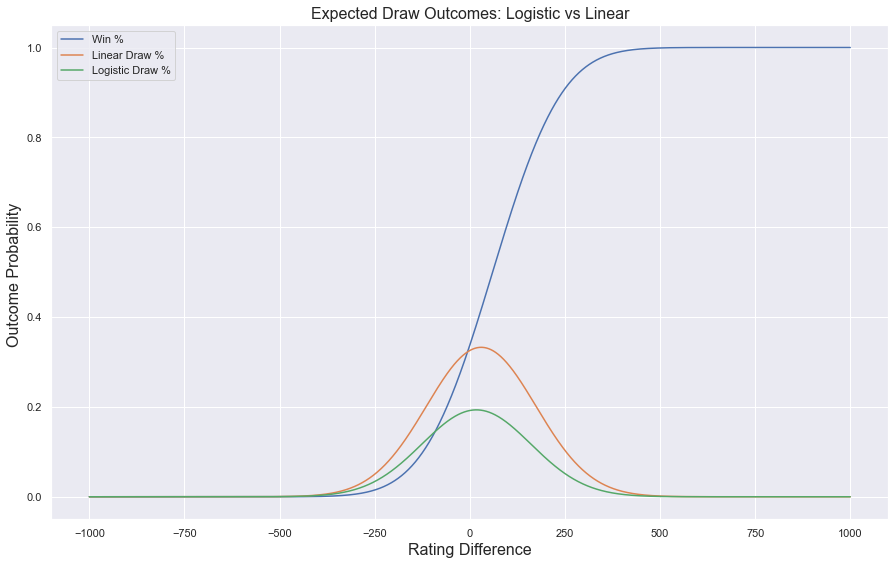

In [543]:
plot_draw_offset()

The closer the H2H outcome probability is to 50%, the higher the probability of a draw. Unfortunately, this chart doesn't really help us. This chart plots matchups from Elo 500 vs. 2500 --> 2500 vs. 500. All of these matchups have an avg Elo of 1500 Which locks the logistic draw % in place. Lets fix it. 

Ex. (Draws = logistic)
Player 1: 2400 Elo, Player 2: 2450 Elo

Elo Expected Score: Logistic Distribution - High Rating
Outcome       Win %
---------  --------
P1 Win     0.218639
P2 Win     0.357559
Draw       0.423802

Player 1: 1400 Elo, Player 2: 1450 Elo
Elo Expected Score: Logistic Distribution - Low Rating 
Outcome       Win %
---------  --------
P1 Win     0.344294
P2 Win     0.483214
Draw       0.172493

Ex. (Draws = linear)
Player 1: 2400 Elo, Player 2: 2450 Elo

Elo Expected Score: Logistic Distribution - High Rating
Outcome       Win %
---------  --------
P1 Win     0.275922
P2 Win     0.414842
Draw       0.309236

Player 1: 1400 Elo, Player 2: 1450 Elo
Elo Expected Score: Logistic Distribution - Low Rating
Outcome       Win %
---------  --------
P1 Win     0.275922
P2 Win     0.414842
Draw       0.309236


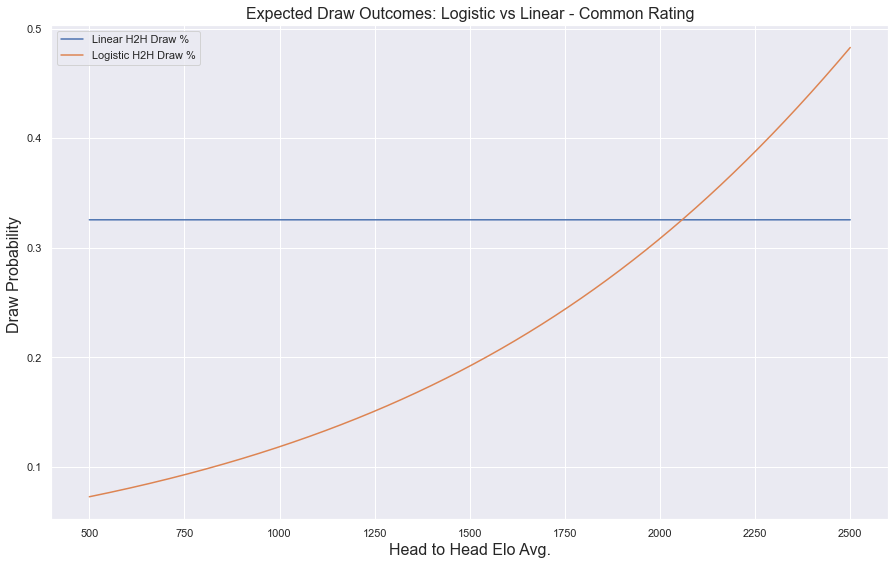

In [544]:
print("Ex. (Draws = logistic)")
print("Player 1: 2400 Elo, Player 2: 2450 Elo\n")
print("Elo Expected Score: Logistic Distribution - High Rating")
print(expected_scores(2400, 2450, True)[0])
print("\nPlayer 1: 1400 Elo, Player 2: 1450 Elo")
print("Elo Expected Score: Logistic Distribution - Low Rating ")
print(expected_scores(1400, 1450, True)[0])

print("\nEx. (Draws = linear)")
print("Player 1: 2400 Elo, Player 2: 2450 Elo\n")
print("Elo Expected Score: Logistic Distribution - High Rating")
print(expected_scores(2400, 2450)[0])
print("\nPlayer 1: 1400 Elo, Player 2: 1450 Elo")
print("Elo Expected Score: Logistic Distribution - Low Rating")
print(expected_scores(1400, 1450)[0])

plot_draw_avg_rating()

Here we can clearly see how a dynamic draw % reacts to H2H's with differing average Elos. As the averages increase, so does the draw probability. While the dynamic draw probability may be better suited for chess, for our case we're going to stick with the constant draw rate as I believe it is more versatile. 

Elo: Homefield Advantage
--

![](https://c.tenor.com/U_yYYGkxrs4AAAAC/liverpool-anfield.gif)


Elo rating can be one of many factors when taking H2H matchups into account. Maybe not in chess, but in many sports homefield advantage is a real thing and can tilt the scales in a close matchup. We can take this into account in our Elo model.

In [545]:
# Calculating Homefield Advantage
def expected_H2H_scores(rat_a: float, rat_b: float, home_adv=0) -> str:
    def elo_log(elo_diff: float) -> float:
        return math.erfc(-(elo_diff) / ((2000/7) * math.sqrt(2))) / 2

    def elo_draw_offset(elo: float) -> int:
        # This draw constant may need to be tinkered with
        return 200
    
    # Remember, diff needs to be negative for elo_log() to function properly.
    # This may require modifying the formula within the function or implementing
    # parameter validation.
    diff = rat_a - rat_b + home_adv
    average = (rat_a + rat_b) / 2
    expected_score = elo_log(diff)
    edo = elo_draw_offset(average)
    
    elo_shift = edo * 0.6

    p1_win_prob = p2_loss_prob = elo_log(diff - elo_shift)
    draw_prob = (expected_score - p1_win_prob) * 2
    p2_win_prob = p1_loss_prob = 1 - (p1_win_prob + draw_prob)

    output = [["P1 Win", p1_win_prob],["P2 Win", p2_win_prob],["Draw", draw_prob]]
    
    return log_dict_sim(output), p1_win_prob, p1_loss_prob, draw_prob

Homefield advantage is only one of many factors you can add into your Elo model. Let's checkout the logs.

In [546]:
print("\nEx. (P1 Underdog Matchup)")
print("Player 1: 2300 Elo, Player 2: 2500 Elo\n")
print("Elo Expected Score: P1 w/ No Homefield Adv.")
print(expected_H2H_scores(2300, 2500)[0])
print("\nElo Expected Score: P1 w/ Avg. Homefield Adv.")
print(expected_H2H_scores(2300, 2500, 68)[0])
print("\nElo Expected Score: P1 w/ Significant Homefield Adv.")
print(expected_H2H_scores(2300, 2500, 140)[0])

print("\nEx. (P1 Equal Matchup)")
print("Player 1: 2450 Elo, Player 2: 2500 Elo\n")
print("Elo Expected Score: P1 w/ No Homefield Adv.")
print(expected_H2H_scores(2450, 2500)[0])
print("\nElo Expected Score: P1 w/ Avg. Homefield Adv.")
print(expected_H2H_scores(2450, 2500, 68)[0])
print("\nElo Expected Score: P1 w/ Significant Homefield Adv.")
print(expected_H2H_scores(2450, 2500, 140)[0])


Ex. (P1 Underdog Matchup)
Player 1: 2300 Elo, Player 2: 2500 Elo

Elo Expected Score: P1 w/ No Homefield Adv.
Outcome      Prob. %
---------  ---------
P1 Win      0.131357
P2 Win      0.64743
Draw        0.221214

Elo Expected Score: P1 w/ Avg. Homefield Adv.
Outcome      Prob. %
---------  ---------
P1 Win      0.188888
P2 Win      0.544807
Draw        0.266305

Elo Expected Score: P1 w/ Significant Homefield Adv.
Outcome      Prob. %
---------  ---------
P1 Win      0.264347
P2 Win      0.43068
Draw        0.304973

Ex. (P1 Equal Matchup)
Player 1: 2450 Elo, Player 2: 2500 Elo

Elo Expected Score: P1 w/ No Homefield Adv.
Outcome      Prob. %
---------  ---------
P1 Win      0.275922
P2 Win      0.414842
Draw        0.309236

Elo Expected Score: P1 w/ Avg. Homefield Adv.
Outcome      Prob. %
---------  ---------
P1 Win      0.360546
P2 Win      0.310312
Draw        0.329142

Elo Expected Score: P1 w/ Significant Homefield Adv.
Outcome      Prob. %
---------  ---------
P1 Win      0.

We've wrapped up our Elo model. Adding variables + constants such as draw probability or homefield advantage can always be adjusted in the future to improve accuracy. Lets implement the rating system. 


Elo: Rating System
--

Each player has an Elo rating. That rating gets updated after a H2H based on the player's Elo, the opponent's Elo, and the K-factor. The K-factor determines the severity of the rating change after a H2H. A lower K-factor means larger swings in your Elo, a higher k-factor means smaller swings.

FIDE and USCF have their own K-factor scales built around their custom Elo systems. Let's look at FIDE's.


**FIDE K-factor:**


- `K = 40` --> Total matches `< 30`

- `K = 20` --> ATH Elo rating `< 2400`

- `K = 10` --> ATH Elo rating `> 2400` $\wedge$ Total matches `> 30`


We're going to use `K = 20`. `K = 40` would give us too much volatility and `K = 10`, not enough volatility.

---

`rating_change()`

Calculates new Elo for each player after H2H match. Because we tinkered a lot with our custom `expected_H2H_scores()` function, we're going to use the original `expected_scores_normal_dis()` Elo formula just for handling rating change. These are our two main functions. One for estimating H2H outcomes and another for handling Elo change.

---

`sim_match()`

Based on the output above, we know that `Win % + Draw % + Loss % = 1`. When a match begins, a random number `0 ≤ num ≤ 1` will be generated. Each potential outcome percentage will serve as a bounds. The H2H is determined by which bounds the random number falls within. The ordering of the bounds is arbitrary as long as it is uniform among all rounds.

Ex.

```
0   Win     Loss     Draw   1
|---------|------|----------|
        ^
        |
       num 
       
Outcome: Win!
```

---



In [547]:
import random

def rating_change(rat_a: float, rat_b: float, result: float) -> list:
    rating_scores = expected_scores_normal_dis(rat_a, rat_b)
    '''
    rat_a: int -> Lower rated
    rat_b: int -> Higher rated
    K-factor = 20
    '''

    new_rating_a = rat_a + 20 * (result - rating_scores[1])
    new_rating_b = rat_b + 20 * ((1 - result) - rating_scores[2])
    
    return new_rating_a, new_rating_b

def sim_match(rat_a: float, rat_b: float) -> list:
    rand_float = random.random()
    print(f"Game seed: {rand_float}")
    
    outcome_bounds = expected_H2H_scores(rat_a, rat_b)
    print(outcome_bounds[0])
    
    new_ratings = None
    h2h_outcome = None

    if rand_float < outcome_bounds[1]:
        # playerA won = playerB lost
        new_ratings = rating_change(rat_a, rat_b, 1)
        h2h_outcome = "Player A Wins!"
    elif rand_float < outcome_bounds[1] + outcome_bounds[2]:
       # playerB won = playerA lost
        new_ratings = rating_change(rat_a, rat_b, 0)
        h2h_outcome = "Player B Wins!"
    else:
        # Draw
        new_ratings = rating_change(rat_a, rat_b, .5)
        h2h_outcome = "Draw!"
    
    return new_ratings, h2h_outcome

In [551]:
class Player:
    def __init__(self, name: str, elo: int, home_adv: int):
        self.name = name
        self.elo = elo
        self.home_adv = home_adv
    
    def set_elo(self, elo: int) -> None:
        self.elo = elo
    
p1 = Player("Vladimir Petrov", 1600, 0)
p2 = Player("Nikolai Kallas", 1900, 0)

initial_elos = [p1.elo, p2.elo]

p1_wins = p2_wins = 0

print("Initial Elos:")
print(f"(P1) {p1.name}: {p1.elo}")
print(f"(P2) {p2.name}: {p2.elo}")

for i in range(5):
    print(f"\nMatch {i + 1}:")
    match_sim = sim_match(p1.elo, p2.elo)
    p1.elo, p2.elo = match_sim[0]
    if match_sim[1] == "Player A Wins!":
        p1_wins += 1
        print("H2H outcome: Petrov wins!")
    elif match_sim[1] == "Player B Wins!":
        p2_wins += 1
        print("H2H outcome: Kallas wins!")
    else:
        print("H2H outcome: Draw!")
    
    
print("\nFinal Elos:")
print(f"{p1.name}: {initial_elos[0]} --> {round(p1.elo)} --> {p1_wins}/5")
print(f"{p2.name}: {initial_elos[1]} --> {round(p2.elo)} --> {p2_wins}/5")

Initial Elos:
(P1) Vladimir Petrov: 1600
(P2) Nikolai Kallas: 1900

Match 1:
Game seed: 0.43504572782863693
Outcome      Prob. %
---------  ---------
P1 Win     0.0707809
P2 Win     0.777063
Draw       0.152156
H2H outcome: Kallas wins!

Match 2:
Game seed: 0.8546507586678096
Outcome      Prob. %
---------  ---------
P1 Win     0.0679627
P2 Win     0.783855
Draw       0.148182
H2H outcome: Draw!

Match 3:
Game seed: 0.05569265935858714
Outcome      Prob. %
---------  ---------
P1 Win     0.0746994
P2 Win     0.767757
Draw       0.157544
H2H outcome: Petrov wins!

Match 4:
Game seed: 0.23121375621491547
Outcome      Prob. %
---------  ---------
P1 Win     0.0928104
P2 Win     0.726627
Draw       0.180563
H2H outcome: Kallas wins!

Match 5:
Game seed: 0.31365365619978003
Outcome      Prob. %
---------  ---------
P1 Win     0.0885924
P2 Win     0.735949
Draw       0.175459
H2H outcome: Kallas wins!

Final Elos:
Vladimir Petrov: 1600 --> 1614 --> 1/5
Nikolai Kallas: 1900 --> 1886 --> 3/5
